# L7: Build a Crew to Tailor Job Applications

We will create crew of agents that will help you to apply for jobs . This agents will be able to look into the job postings. Understand its requirements and then use that over in current resume and your skills and agents will make sure that we tailor the resume according to the job posting so that you can apply for jobs

In this lesson, you will built your first multi-agent system.

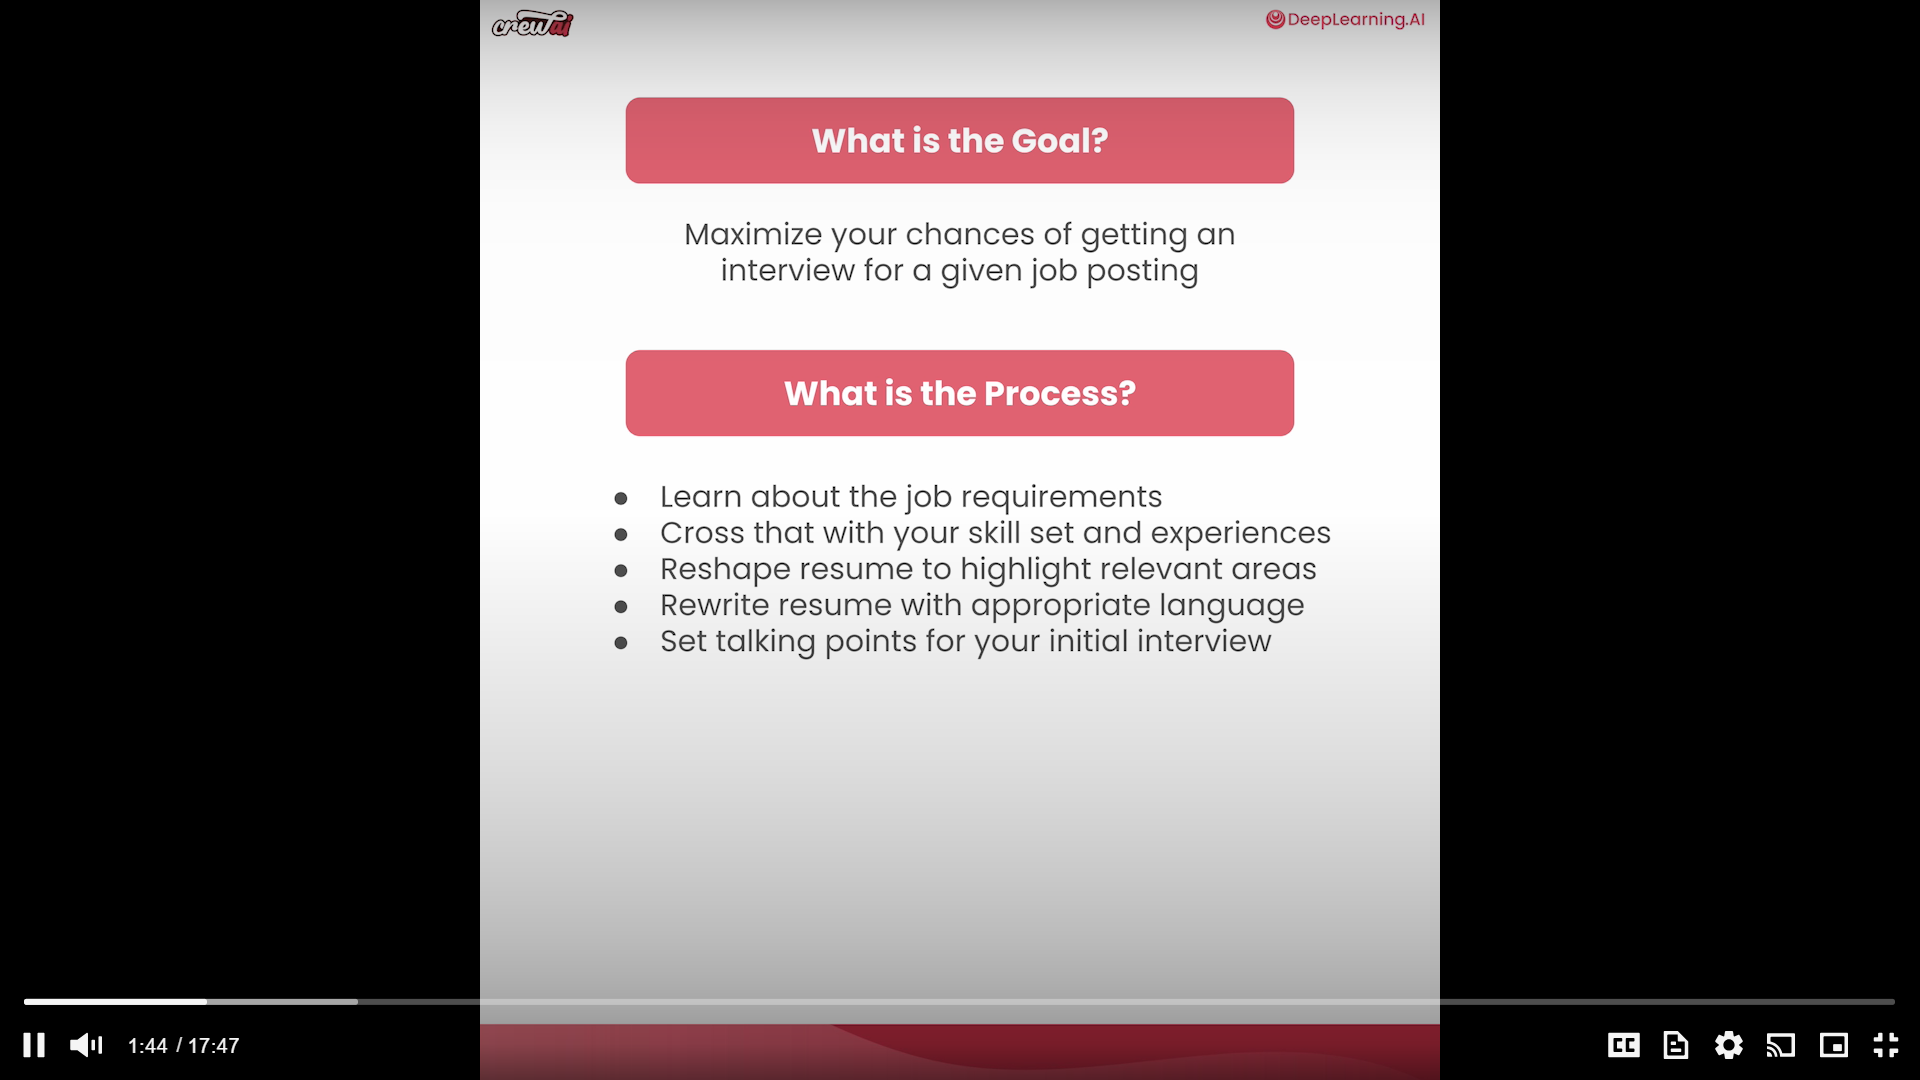

The libraries are already installed in the classroom. If you're running this notebook on your own machine, you can install the following:
```Python
!pip install crewai==0.28.8 crewai_tools==0.1.6 langchain_community==0.0.29
```

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

- Import libraries, APIs and LLM

In [2]:
from crewai import Agent, Task, Crew

**Note**: 
- The video uses `gpt-4-turbo`, but due to certain constraints, and in order to offer this course for free to everyone, the code you'll run here will use `gpt-3.5-turbo`.
- You can use `gpt-4-turbo` when you run the notebook _locally_ (using `gpt-4-turbo` will not work on the platform)
- Thank you for your understanding!

In [3]:
import os
from utils import get_openai_api_key, get_serper_api_key

openai_api_key = get_openai_api_key()
os.environ["OPENAI_MODEL_NAME"] = 'gpt-3.5-turbo'
os.environ["SERPER_API_KEY"] = get_serper_api_key()

## crewAI Tools

In [4]:
from crewai_tools import (
  FileReadTool,
  ScrapeWebsiteTool,
  MDXSearchTool,
  SerperDevTool
)

search_tool = SerperDevTool()
scrape_tool = ScrapeWebsiteTool()
read_resume = FileReadTool(file_path='./fake_resume.md') ## Read files from local
semantic_search_resume = MDXSearchTool(mdx='./fake_resume.md') ## This will allow us to perform RAG on resume

Inserting batches in chromadb: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]


- Uncomment and run the cell below if you wish to view `fake_resume.md` in the notebook.

In [ ]:
# from IPython.display import Markdown, display
# display(Markdown("./fake_resume.md"))

## Creating Agents

In [5]:
# Agent 1: Researcher
researcher = Agent(
    role="Tech Job Researcher",
    goal="Make sure to do amazing analysis on "
         "job posting to help job applicants",
    tools = [scrape_tool, search_tool],
    verbose=True,
    backstory=(
        "As a Job Researcher, your prowess in "
        "navigating and extracting critical "
        "information from job postings is unmatched."
        "Your skills help pinpoint the necessary "
        "qualifications and skills sought "
        "by employers, forming the foundation for "
        "effective application tailoring."
    )
)

In [6]:
# Agent 2: Profiler ## It will look into job posting and resume . Highlight imp points
profiler = Agent(
    role="Personal Profiler for Engineers",
    goal="Do increditble research on job applicants "
         "to help them stand out in the job market",
    tools = [scrape_tool, search_tool,
             read_resume, semantic_search_resume],
    verbose=True,
    backstory=(
        "Equipped with analytical prowess, you dissect "
        "and synthesize information "
        "from diverse sources to craft comprehensive "
        "personal and professional profiles, laying the "
        "groundwork for personalized resume enhancements."
    )
)

In [7]:
# Agent 3: Resume Strategist ## Update the resume 
resume_strategist = Agent(
    role="Resume Strategist for Engineers",
    goal="Find all the best ways to make a "
         "resume stand out in the job market.",
    tools = [scrape_tool, search_tool,
             read_resume, semantic_search_resume],
    verbose=True,
    backstory=(
        "With a strategic mind and an eye for detail, you "
        "excel at refining resumes to highlight the most "
        "relevant skills and experiences, ensuring they "
        "resonate perfectly with the job's requirements."
    )
)

In [8]:
# Agent 4: Interview Preparer
interview_preparer = Agent(
    role="Engineering Interview Preparer",
    goal="Create interview questions and talking points "
         "based on the resume and job requirements",
    tools = [scrape_tool, search_tool,
             read_resume, semantic_search_resume],
    verbose=True,
    backstory=(
        "Your role is crucial in anticipating the dynamics of "
        "interviews. With your ability to formulate key questions "
        "and talking points, you prepare candidates for success, "
        "ensuring they can confidently address all aspects of the "
        "job they are applying for."
    )
)

## Creating Tasks

In [9]:
# Task for Researcher Agent: Extract Job Requirements
research_task = Task(
    description=(
        "Analyze the job posting URL provided ({job_posting_url}) "
        "to extract key skills, experiences, and qualifications "
        "required. Use the tools to gather content and identify "
        "and categorize the requirements."
    ),
    expected_output=(
        "A structured list of job requirements, including necessary "
        "skills, qualifications, and experiences."
    ),
    agent=researcher,
    async_execution=True
)

In [10]:
# Task for Profiler Agent: Compile Comprehensive Profile
profile_task = Task(
    description=(
        "Compile a detailed personal and professional profile "
        "using the GitHub ({github_url}) URLs, and personal write-up "
        "({personal_writeup}). Utilize tools to extract and "
        "synthesize information from these sources."
    ),
    expected_output=(
        "A comprehensive profile document that includes skills, "
        "project experiences, contributions, interests, and "
        "communication style."
    ),
    agent=profiler,
    async_execution=True
)

- You can pass a list of tasks as `context` to a task.
- The task then takes into account the output of those tasks in its execution.
- The task will not run until it has the output(s) from those tasks.

In [11]:
# Task for Resume Strategist Agent: Align Resume with Job Requirements
resume_strategy_task = Task(
    description=(
        "Using the profile and job requirements obtained from "
        "previous tasks, tailor the resume to highlight the most "
        "relevant areas. Employ tools to adjust and enhance the "
        "resume content. Make sure this is the best resume even but "
        "don't make up any information. Update every section, "
        "inlcuding the initial summary, work experience, skills, "
        "and education. All to better reflrect the candidates "
        "abilities and how it matches the job posting."
    ),
    expected_output=(
        "An updated resume that effectively highlights the candidate's "
        "qualifications and experiences relevant to the job."
    ),
    output_file="tailored_resume.md",
    context=[research_task, profile_task],
    agent=resume_strategist
)

In [12]:
# Task for Interview Preparer Agent: Develop Interview Materials
interview_preparation_task = Task(
    description=(
        "Create a set of potential interview questions and talking "
        "points based on the tailored resume and job requirements. "
        "Utilize tools to generate relevant questions and discussion "
        "points. Make sure to use these question and talking points to "
        "help the candiadte highlight the main points of the resume "
        "and how it matches the job posting."
    ),
    expected_output=(
        "A document containing key questions and talking points "
        "that the candidate should prepare for the initial interview."
    ),
    output_file="interview_materials.md",
    context=[research_task, profile_task, resume_strategy_task],
    agent=interview_preparer
)


## Creating the Crew

In [13]:
job_application_crew = Crew(
    agents=[researcher,
            profiler,
            resume_strategist,
            interview_preparer],

    tasks=[research_task,
           profile_task,
           resume_strategy_task,
           interview_preparation_task],

    verbose=True
)

## Running the Crew

- Set the inputs for the execution of the crew.

In [14]:
job_application_inputs = {
    'job_posting_url': 'https://jobs.lever.co/AIFund/6c82e23e-d954-4dd8-a734-c0c2c5ee00f1?lever-origin=applied&lever-source%5B%5D=AI+Fund',
    'github_url': 'https://github.com/joaomdmoura',
    'personal_writeup': """Noah is an accomplished Software
    Engineering Leader with 18 years of experience, specializing in
    managing remote and in-office teams, and expert in multiple
    programming languages and frameworks. He holds an MBA and a strong
    background in AI and data science. Noah has successfully led
    major tech initiatives and startups, proving his ability to drive
    innovation and growth in the tech industry. Ideal for leadership
    roles that require a strategic and innovative approach."""
}

**Note**: LLMs can provide different outputs for they same input, so what you get might be different than what you see in the video.

In [15]:
### this execution will take a few minutes to run
result = job_application_crew.kickoff(inputs=job_application_inputs)

 [DEBUG]: == Working Agent: Tech Job Researcher
 [INFO]: == Starting Task: Analyze the job posting URL provided (https://jobs.lever.co/AIFund/6c82e23e-d954-4dd8-a734-c0c2c5ee00f1?lever-origin=applied&lever-source%5B%5D=AI+Fund) to extract key skills, experiences, and qualifications required. Use the tools to gather content and identify and categorize the requirements.
 [DEBUG]: == [Tech Job Researcher] Task output: 


 [DEBUG]: == Working Agent: Personal Profiler for Engineers
 [INFO]: == Starting Task: Compile a detailed personal and professional profile using the GitHub (https://github.com/joaomdmoura) URLs, and personal write-up (Noah is an accomplished Software
    Engineering Leader with 18 years of experience, specializing in
    managing remote and in-office teams, and expert in multiple
    programming languages and frameworks. He holds an MBA and a strong
    background in AI and data science. Noah has successfully led
    major tech initiatives and startups, proving his abili

Action: Read website content
Action Input: {"website_url": "https://crewai.com"} 

crewAI - Platform for Multi AI Agents Systems
×
 Documentation
 Chat with our docs
 Join our Discord
 Blog
Menu
×
Documentation
Chat with our docs
Join our Discord
Blog
Login
Sign Up
														AI Agents forreal use cases
														Most AI agent frameworks are hard to use.
														We provide power with simplicity.
														Automate your most important workflows quickly.
1,400,000+
Multi-Agent Crews run last 7 days using crewAI.
																CrewAI+ for Enterprises
																	The framework
																	Documentation
																	Chat with our docs
										Production Ready 
Multi Agent Automations
								Become a certified crewAI Engineer
								OpenSource
								Enterprise
										Use our Open Source tools
										Use our developer framework and tools to build your own multi-agent automations locally.
										Turn into API's
										Turn any Multi Agent crew

Final Answer:
# Noah Williams
- Email: noah.williams@example.dev
- Phone: +44 11 111 11111

## Summary
Noah Williams is an accomplished Software Engineering Leader with 18 years of experience, specializing in managing remote and in-office teams, and expert in multiple programming languages and frameworks. He holds an MBA and a strong background in AI and data science. Noah has successfully led major tech initiatives and startups, proving his ability to drive innovation and growth in the tech industry. Ideal for leadership roles that require a strategic and innovative approach.

## Work Experience

### Director of Software Engineering at DataKernel (remote) - 2022 - Present
- Transformed the engineering division into a key revenue pillar for DataKernel, expanding the customer base and integrating cutting-edge AI technologies.
- Spearheaded strategic initiatives in adopting AI technologies that set new benchmarks within the industry.

### Senior Software Engineering Manager at DataKernel

Final Answer:

**Interview Questions and Talking Points for Noah Williams:**

1. Can you walk us through your experience in transforming the engineering division at DataKernel into a key revenue pillar and expanding the customer base with cutting-edge AI technologies?

2. How have you leveraged your expertise in programming languages like Python, Ruby, and Elixir to lead both remote and in-office engineering teams effectively?

3. What strategic initiatives have you spearheaded in adopting AI technologies at DataKernel that have set new benchmarks within the industry?

4. Could you share a specific project where you successfully developed and deployed APIs for enterprise solutions, showcasing your expertise in this area?

5. How did you manage diverse teams across multiple time zones at DataKernel, and what strategies did you implement to enhance team performance and morale?

6. In your role as the Founder & CEO of InnovPet, how did you oversee product development from concept to execu

- Dislplay the generated `tailored_resume.md` file.

In [16]:
from IPython.display import Markdown, display
display(Markdown("./tailored_resume.md"))

# Noah Williams
- Email: noah.williams@example.dev
- Phone: +44 11 111 11111

## Summary
Noah Williams is an accomplished Software Engineering Leader with 18 years of experience, specializing in managing remote and in-office teams, and expert in multiple programming languages and frameworks. He holds an MBA and a strong background in AI and data science. Noah has successfully led major tech initiatives and startups, proving his ability to drive innovation and growth in the tech industry. Ideal for leadership roles that require a strategic and innovative approach.

## Work Experience

### Director of Software Engineering at DataKernel (remote) - 2022 - Present
- Transformed the engineering division into a key revenue pillar for DataKernel, expanding the customer base and integrating cutting-edge AI technologies.
- Spearheaded strategic initiatives in adopting AI technologies that set new benchmarks within the industry.

### Senior Software Engineering Manager at DataKernel (remote) - 2019 - 2022
- Directed engineering strategy and operations, managed diverse teams across multiple time zones, and played a crucial role in shaping the company's technological trajectory.

### Founder & CEO at InnovPet (remote) - 2019 - 2022
- Founded a startup focusing on innovative IoT solutions for pet care, overseeing product development and setting up successful funding phases.

### Engineering Manager at EliteDevs (remote) - 2018 - 2019
- Formulated and executed strategic plans that enhanced inter-departmental coordination and trust, managed multiple engineering teams.

### Engineering Manager at PrintPack (remote) - 2016 - 2018
- Led the development of a high-performance engineering team that increased company revenue and integrated data analytics into business decision-making processes.

### Senior Software Engineer at DriveAI (remote) - 2015 - 2016
- Developed and optimized a central API that improved system performance and user satisfaction, implemented critical enhancements.

### CTO at BetCraft - 2013 - 2015
- Led the technology strategy post-Series A funding, improved platform performance, and expanded market reach.

## Skills
- Proficient in multiple programming languages and frameworks including Python, Ruby, and Elixir
- Experienced in managing remote and in-office teams
- Strong background in AI and data science
- Skilled in building and deploying multi-agent systems
- Expertise in developing and deploying APIs
- Familiar with gamification techniques and implementation

## Education
- MBA in Information Technology from London Business School
- Advanced Leadership Techniques Certification from University of London
- Data Science Specialization Certification from Coursera (Johns Hopkins University)
- B.Sc. in Computer Science from University of Edinburgh

Noah Williams is an ideal candidate for senior executive roles, particularly in companies seeking leadership with a robust blend of technical and strategic expertise.

- Dislplay the generated `interview_materials.md` file.

In [17]:
display(Markdown("./interview_materials.md"))

**Interview Questions and Talking Points for Noah Williams:**

1. Can you walk us through your experience in transforming the engineering division at DataKernel into a key revenue pillar and expanding the customer base with cutting-edge AI technologies?

2. How have you leveraged your expertise in programming languages like Python, Ruby, and Elixir to lead both remote and in-office engineering teams effectively?

3. What strategic initiatives have you spearheaded in adopting AI technologies at DataKernel that have set new benchmarks within the industry?

4. Could you share a specific project where you successfully developed and deployed APIs for enterprise solutions, showcasing your expertise in this area?

5. How did you manage diverse teams across multiple time zones at DataKernel, and what strategies did you implement to enhance team performance and morale?

6. In your role as the Founder & CEO of InnovPet, how did you oversee product development from concept to execution, particularly in implementing MongoDB for the initial product version?

7. What leadership qualities did you exhibit at EliteDevs that led to enhancing inter-departmental coordination and trust, resulting in better project outcomes?

8. Can you discuss a specific instance where you integrated data analytics into business decision-making processes at PrintPack, leading to the development of a predictive modeling tool?

9. How did you optimize a central API at DriveAI to improve system performance and user satisfaction, and what critical enhancements did you implement?

10. As the CTO at BetCraft, how did you lead the technology strategy post-Series A funding and improve platform performance using React and Angular?

Talking Points:
- Experience in managing remote and in-office teams
- Expertise in AI and data science
- Proficiency in multiple programming languages and frameworks
- Development and deployment of APIs
- Strategic initiatives in adopting AI technologies
- Integration of data analytics into business decision-making
- Leadership qualities fostering team performance and morale
- Entrepreneurial acumen in founding InnovPet
- Educational background in IT, leadership, and computer science

By preparing and addressing these questions and talking points, Noah Williams can effectively highlight his key skills, experiences, and achievements that align with the job requirements and showcase his suitability for leadership roles within the tech industry.

# CONGRATULATIONS!!!

## Share your accomplishment!
- Once you finish watching all the videos, you will see the "In progress" image on the bottom left turn into "Accomplished".
- Click on "Accomplished" to view the course completion page with your name on it.
- Take a screenshot and share on LinkedIn, X (Twitter), or Facebook.  
- **Tag @Joāo (Joe) Moura, @crewAI, and @DeepLearning.AI, (and a few of your friends if you'd like them to try out the course)**
- **Joāo and DeepLearning.AI will "like"/reshare/comment on your post!**

## Get a completion badge that you can add to your LinkedIn profile!
- Go to [learn.crewai.com](https://learn.crewai.com).
- Upload your screenshot of your course completion page.
- You'll get a badge from CrewAI that you can share!

(Joāo will also talk about this in the last video of the course.)